In [36]:
import random

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image


def plot_hands3d(ax, points, color, linewidth='3'):
    # Add bone connections
    bones = [(13, 11),
             (13, 12),
             (13, 1),
             (0, 1),
             (13, 3),
             (2, 3),
             (13, 5),
             (4, 5),
             (13, 7),
             (6, 7),
             (13, 10),
             (9, 10),
             (8, 9)]

    for connection in bones:
        coord1 = points[connection[0]]
        coord2 = points[connection[1]]
        coords = np.stack([coord1, coord2])
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], c=color, linewidth=linewidth)

# NYU Hand Pose Dataset

The [NYU Hand Pose Dataset](https://jonathantompson.github.io/NYU_Hand_Pose_Dataset.htm) was published in 2014. It provides 72,757 training frames and 8,252 test frames captured with RGB-D cameras (Kinect 1). Keypoint annotations are provided for each frame.

In [37]:
# Load dataset
testing_mat = sio.loadmat("data/test_joint_data.mat")
training_mat = sio.loadmat("data/train_joint_data.mat")
test_dataset = testing_mat['joint_uvd'][0]
train_dataset = training_mat['joint_uvd'][0]

# Show a sample
eval_joints = [0, 3, 6, 9, 12, 15, 18, 21, 24, 25, 27, 30, 31, 32]
train_dataset = train_dataset[:, eval_joints]
test_dataset = test_dataset[:, eval_joints]

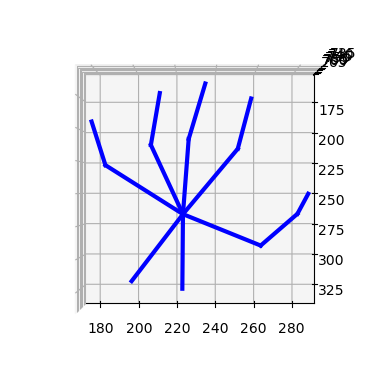

In [38]:
sample = train_dataset[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(-90, -90)
plot_hands3d(ax, sample, 'b')

# Data Normalization

Normalization is extremely important when comparing two samples of any data type. Consider a model that detects the keypoints of a hand from two separate images. Depending on the relative location of the hand in the image, the coordinates will vary greatly.

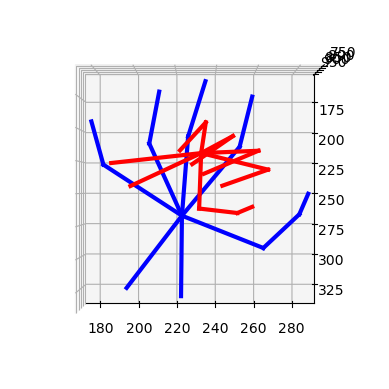

In [39]:
x1 = train_dataset[0]
x2 = train_dataset[10000]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(-90, -90)
plot_hands3d(ax, x1, 'b')
plot_hands3d(ax, x2, 'r')

Normalization can resolve the change in relative size so that a fair comparison can be made. For this particular dataset, we will normalize each sample based on its size and set the origin to be the center of the palm.

In [40]:
def normalize_hand(points):
    """Normalize the hand and center it on the palm"""

    center = points[-1]  # The palm keypoint
    scale_factor = 1.0 / (points.max(0)[0] - points.min(0)[0])
    norm_points = points.copy()
    norm_points -= center
    norm_points *= scale_factor

    return norm_points

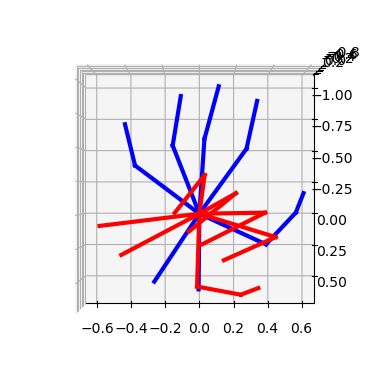

In [41]:
x1_norm = normalize_hand(x1)
x2_norm = normalize_hand(x2)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.view_init(-90, -90)
plot_hands3d(ax1, x1_norm, 'b')
plot_hands3d(ax1, x2_norm, 'r')

# Finding the Closest Match

In this notebook, the goal is to complete the function `find_closest_match` to retrieve samples in the dataset that most closely match an input sample based on either L1 or L2 loss.

In [77]:
def computeL1Loss(u : np.array, v : np.array) -> np.array:
    return np.sum(np.abs(u-v))

def computeL2Loss(u : np.array, v : np.array) -> np.array:
    return np.sum(np.dot(u-v, (u-v).T))

In [78]:
def find_closest_match(x, dataset, loss_fn):
    """Searches the `dataset` for the sample that has the lowest
    error as compared with `loss_fn`.
    """
    # TODO: Implement a search based on the lowest loss as given by `loss_fn`
    return_index = 1
    normalized_x = normalize_hand(x)
    curr_lowest_loss = loss_fn(normalized_x, normalize_hand(dataset[return_index]))
    for index, datapoint in enumerate(dataset):
        curr_loss = loss_fn(normalized_x, normalize_hand(datapoint))
        if curr_loss < curr_lowest_loss:
            return_index = index
            curr_lowest_loss = curr_loss

    return dataset[return_index]

In [ ]:
input_idx = 50
input_sample = test_dataset[input_idx]

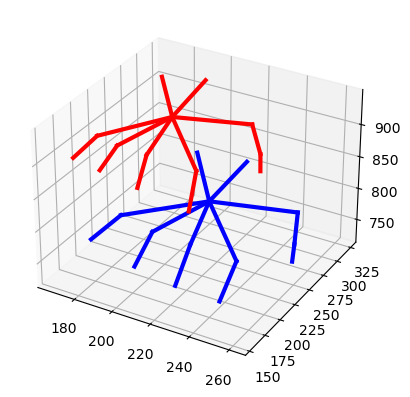

In [86]:
# Search for the closest match with L1 loss function
match = find_closest_match(input_sample, train_dataset, computeL1Loss)

# Visualize Results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_hands3d(ax, input_sample, 'b')
plot_hands3d(ax, match, 'r')

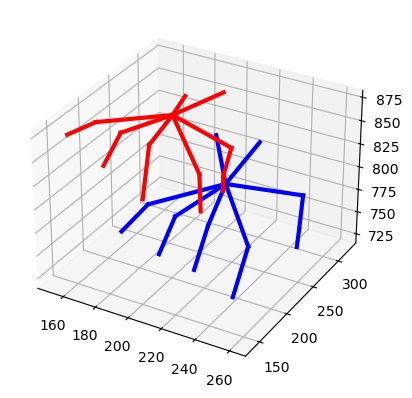

In [87]:
# Search for the closest match with L2 loss function
match = find_closest_match(input_sample, train_dataset, computeL2Loss)

# Visualize Results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_hands3d(ax, input_sample, 'b')
plot_hands3d(ax, match, 'r')